In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib as plt
import ast
from itertools import chain

In [2]:
df = pd.read_csv("data/full_set.csv")
TARGET_CLASS = "CHM2210"
df.shape

(588793, 31)

In [3]:
# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes
127,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]"
128,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101]
129,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]"
130,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]"


In [4]:
# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename(f'{TARGET_CLASS}_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df[f'{TARGET_CLASS}_Semester']]

/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_27039/3075685398.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename(f'{TARGET_CLASS}_Semester')


In [5]:
# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = [f'{TARGET_CLASS}_Points', f'{TARGET_CLASS}_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df[f'{TARGET_CLASS}_Grade'].isin(['WE', 'IF', 'W', 'WC'])]

/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_27039/3005008596.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)


In [6]:
display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df[f'{TARGET_CLASS}_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
grouped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    f'{TARGET_CLASS}_Grade': 'first',
    f'{TARGET_CLASS}_Points': 'first',
}).reset_index()

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,CHM2210_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,CHM2210_Semester,CHM2210_Points,CHM2210_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


In [7]:
grouped_df.head(5)

,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,CHM2210_Grade,CHM2210_Points
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67
3,1096567,3.85,1340.0,"[A-, A-, B-, W, A+, D, B, A+, B+, B, A, A+, A-...","[3.67, 3.67, 2.67, 0.0, 4.0, 1.0, 3.0, 4.0, 3....","[MAC1147, ENC1102, CHM2045, CHM2045L, SLS2901,...","[82970.0, 89553.0, 92762.0, 92839.0, 93253.0, ...",C,2.00
4,1302110,2.43,1040.0,[A],[4.0],[PCB3063],[54321.0],A+,4.00


In [10]:
all_classes = sorted(set(chain.from_iterable(grouped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

grouped_df['One_Hot_Classes'] = grouped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(grouped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=grouped_df['Pidm'])

In [11]:
print(grouped_df.shape)
display(grouped_df.head(3))

print(one_hot_df.shape)
display(one_hot_df.head(3))

(11781, 10)


,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,CHM2210_Grade,CHM2210_Points,One_Hot_Classes
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


(11781, 1524)


,ACG2021,ACG2071,ACG3074,ACG3103,ACG3113,ACG3341,ACG3401,ACG4123,ACG4632,ACG4684,ACG5205,ADV2214,ADV3008,AFA2000,AFA2380,AFA3110,AFA4150,AFA4335,AFA4430,AFA4931,AFH3100,AFH3200,AFR1101,AFR1120,AFR2001,AFR2130,AFR2140,AFR3220,AFR3231,AFR4201,AFS2250,AMH2010,AMH2020,AMH3130,AMH3140,AMH3160,AMH3170,AMH3270,AMH3390,AMH3402,AMH3403,AMH3421,AMH3423,AMH3533,AMH3545,AMH3571,AMH3572,AML3031,AML3051,AML3243,AML3604,AML3630,AML3674,AML4111,AMS2030,AMS2270,AMS3700,AMS3930,AMS4804,ANS3006,ANT2000,ANT2410,ANT2464,ANT2511,ANT2511L,ANT2721,ANT3005,ANT3101,ANT3610,ANT4012,ANT4034,ANT4167,ANT4241,ANT4302,ANT4316,ANT4401,ANT4403,ANT4442,ANT4462,ANT4465,ANT4468,ANT4516,ANT4520C,ANT4525,ANT4532,ANT4536,ANT4593,ANT4701,ANT4750,ANT4824,ANT4905,ANT4930,APK3120,APK4138C,APK6109,APK6511,APK6902,ARA1120,ARA1121,ARC2112L,ARC2131C,ARC2135C,ARC2180,ARC2211,ARC2701,ARC2702,ARC2931,ARC4784,ARC5361,ARC5362,ARC5470,ARC5587,ARC5732,ARC5931,ARH2000,ARH2050,ARH2051,ARH3001,ARH4301,ARH4333,ARH4450,ARH4890,ARH4930,ART2201C,ART2203C,ART2301C,ART2344,ART2500C,ART2701C,ART2750C,ART2930,ART3530C,ART3612C,ART3616C,ART4814,ART4905,ART4930,ART4940,ASL2140C,ASL2150C,ASL3514,ASL4161C,ASL4201C,ASL4301C,ASN3012,ASN3014,ASN3030,ASN3201,ASN4414,AST2002,AST2003,AST2004,AST3033,AST3044,AST3930,ATR1000,ATR2010C,ATR3132,BCH3023L,BCH3053,BCH4033,BME3053,BME4100,BME4406,BME4503,BME4508,BME4571,BME4914,BME4931,BME4943,BOT3015C,BOT3152C,BOT3850,BOT4404C,BOT4714C,BOT4851,BSC1005,BSC1020,BSC2010,BSC2010L,BSC2011,BSC2011L,BSC2050,BSC2085,BSC2085L,BSC2086,BSC2086L,BSC2093C,BSC2094C,BSC2932,BSC3022,BSC3312,BSC3368C,BSC3402L,BSC3453,BSC3848,BSC4052,BSC4057,BSC4313C,BSC4315,BSC4333,BSC4444,BSC4454C,BSC4511,BSC4905,BSC4910,BSC4933,BSC4940,BUL3320,CBH4004,CCJ3014,CCJ3024,CCJ3026,CCJ3058,CCJ3117,CCJ3120,CCJ3621,CCJ3632,CCJ3644,CCJ3666,CCJ3701,CCJ3718,CCJ4072,CCJ4361,CCJ4487,CCJ4604,CCJ4613,CCJ4651,CCJ4662,CCJ4681,CCJ4930,CCJ4933,CCJ4934,CDA3103,CDA3201,CDA3201L,CEN3722,CGN4122,CGN4905,CGN4933,CGS1540,CGS2034,CGS2060,CGS2094,CGS2100,CGS3303,CGS3853,CHI1100,CHI1120,CHI1121,CHI1955,CHI2220,CHI2221,CHI3241,CHI3242,CHI4930,CHM2020,CHM2023,CHM2045,CHM2045L,CHM2046,CHM2046L,CHM2210L,CHM2211,CHM3080,CHM3120C,CHM3415C,CHM3610,CHM3610L,CHM3941,CHM4060,CHM4070,CHM4410,CHM4932,CHM4970,CHS2440,CHS2440L,CHS4411,CHT3512,CIS3213,CIS3360,CIS3362,CIS3433,CIS3615,CIS4083,CIS4204,CJC4010,CJE3213,CJE3444,CJE3650,CJE3656,CJE3701,CJE4010,CJE4114,CJE4731,CJL3110,CJL3502,CJL4115,CJL4410,CLA3103,CLA3124,CLA3503,CLA3930,CLP4134,CLP4143,CLP4314,CLP4414,CLP4433,CLP4941,CLT3040,CLT3103,CLT3123,CLT3370,CNT4104,CNT4104L,CNT4403,CNT4603,COM2000,COM2130,COM3014,COM3122,COM4022,COM4027,COM4030,COM4374,COP2030,COP2250,COP2510,COP2512,COP2513,COP2931,COP3331,COP3353,COP3514,COP3515,COP4313,COP4530,COP4538,COP4703,COP4931,COT3100,CPO2002,CPO4034,CPO4930,CRW2100,CRW3013,CRW3111,CRW3112,CRW3121,CRW3311,CRW3312,CRW3321,CRW4930,DAA2100,DAA2104,DAA2200,DAA2204,DAA2500,DAA3108,DAA3209,DAA3214,DAA3294,DAA3395,DAA3614,DAA3615,DAA3624,DAA4211,DAN2100,DAN2160,DAN3584,DAN3615,DAN3714,DAN4134,DAN4434,DAN4906,DEP2004,DEP4053,DEP4220,DIG3950C,ECH3002,ECH3023,ECH3101,ECH3240L,ECH3266,ECH3702,ECH3783,ECH3854,ECH4123,ECH4241L,ECH4267,ECH4323,ECH4418,ECH4504,ECH4605,ECH4615,ECH4615C,ECH4680C,ECH4715,ECH4783,ECH4846,ECH4905,ECH4931,ECH4936,ECH4944,ECO1000,ECO2013,ECO2023,ECO2052,ECO3101,ECO3203,ECO3703,ECO4303,ECO4400,ECO4914,ECO4935,ECP3302,ECP3530,ECS3013,ECS4003,EDE4223,EDE4323,EDE4504,EDE4941,EDF2005,EDF2085,EDF3132,EDF3214,EDF3228,EDF3514,EDF3604,EDF4124,EDF4430,EDF4440,EDF4490,EDF6211,EDG2930,EDG3361,EDG3801,EDG4012,EDG4909,EDP2210,EDP3273,EEE3302,EEE3394,EEE4506,EEL2161,EEL3472C,EEL3705,EEL3705L,EEL4705,EEL4935,EEL4936,EEL6935,EEX4012,EEX4070,EEX4742,EGN1113,EGN3000,EGN3000L,EGN3311,EGN3321,EGN3331,EGN3343,EGN3353,EGN3365,EGN3373,EGN3374,EGN3420,EGN3433,EGN3443,EGN3615,EGN3940,EGN4450,EGN4453,EGN4905,EGN4930,EGS2070,EGS3011,EGS3720,EIN4172,EIN4451,EIN4933,EMA4003,EME2040,EME4390,EML3022,EML3035,EML3041,EML3262,EML3303,EML3500,EML3701,EML4106C,E

### Jude's Splitting Code

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming grouped_df and one_hot_df are already loaded

# Merge grouped_df with one_hot_df on 'Pidm'
merged_df = pd.merge(grouped_df, one_hot_df, left_on='Pidm', right_index=True)

# Remove unuseful columns, i.e., columns with only '-1' values
columns_to_remove = []
for column in one_hot_df.columns:
    if merged_df[column].nunique() == 1 and merged_df[column].unique()[0] == -1:
        columns_to_remove.append(column)

# Drop these columns from the merged dataframe
cleaned_merged_df = merged_df.drop(columns=columns_to_remove)

# Split the cleaned merged data into train, dev, and test sets
train, testing_data = train_test_split(cleaned_merged_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

# Extract train, dev, and test sets
train_set = cleaned_merged_df[cleaned_merged_df.index.isin(train.index)]
dev_set = cleaned_merged_df[cleaned_merged_df.index.isin(dev.index)]
test_set = cleaned_merged_df[cleaned_merged_df.index.isin(test.index)]

# Debugging: Check the shapes and features of the datasets
print("Train Set Shape:", train_set.shape)
print("Dev Set Shape:", dev_set.shape)
print("Test Set Shape:", test_set.shape)

Train Set Shape: (9424, 1534)
Dev Set Shape: (1178, 1534)
Test Set Shape: (1179, 1534)


In [14]:
train_set.to_csv("train_set_cleaned.csv", index=False)
dev_set.to_csv("dev_set_cleaned.csv", index=False)
test_set.to_csv("test_set_cleaned.csv", index=False)

In [15]:
# Create pass/fail column
def map_pass_fail(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']
    return 0 if grade in fail_grades else 1  # 0 = fail, 1 = pass

# Apply the function to create pass/fail column
train_set['pass_fail'] = train_set['CHM2210_Grade'].apply(map_pass_fail)

# Drop irrelevant columns
X = train_set.drop(columns=['Pidm', 'CHM2210_Grade', 'CHM2210_Points', 'Semester Grades', 'Semester Points', 'Classes', 'CRN', 'One_Hot_Classes', 'pass_fail'])

# Convert all remaining object columns to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, 'pass_fail']

/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_27039/2104422588.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['pass_fail'] = train_set['CHM2210_Grade'].apply(map_pass_fail)


In [25]:
from sklearn.utils import resample
# Apply undersampling to balance the classes
# Separate the pass and fail instances
pass_class = X[y == 1]
fail_class = X[y == 0]

# Resample to have 50 instances for both pass and fail
pass_sample = resample(pass_class, replace=False, n_samples=50, random_state=42)
fail_sample = resample(fail_class, replace=False, n_samples=50, random_state=42)

In [26]:
# Combine the undersampled data
X_undersampled = pd.concat([pass_sample, fail_sample])
y_undersampled = pd.concat([y[pass_sample.index], y[fail_sample.index]])

In [44]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],  # Try different learning rates
    'max_depth': [3, 6, 9],             # Try different tree depths
    'n_estimators': [100, 300, 500],     # Number of boosting rounds
    'subsample': [0.8, 1.0],            # Subsample ratio
    'colsample_bytree': [0.8, 1.0]      # Column sampling
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.75


In [45]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Accuracy: 0.65
Confusion Matrix:
[[6 2]
 [5 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.78      0.58      0.67        12

    accuracy                           0.65        20
   macro avg       0.66      0.67      0.65        20
weighted avg       0.68      0.65      0.65        20



In [46]:
X_train.head()

,HS GPA,Converted_SAT,ACG2021,ACG2071,ACG3074,ACG3103,ACG3113,ACG3341,ACG3401,ACG4123,ACG4632,ACG4684,ACG5205,ADV2214,ADV3008,AFA2000,AFA2380,AFA3110,AFA4150,AFA4335,AFA4430,AFA4931,AFH3100,AFH3200,AFR1101,AFR1120,AFR2001,AFR2130,AFR2140,AFR3220,AFR3231,AFR4201,AFS2250,AMH2010,AMH2020,AMH3130,AMH3140,AMH3160,AMH3170,AMH3270,AMH3390,AMH3402,AMH3403,AMH3421,AMH3423,AMH3533,AMH3545,AMH3571,AMH3572,AML3031,AML3051,AML3243,AML3604,AML3630,AML3674,AML4111,AMS2030,AMS2270,AMS3700,AMS3930,AMS4804,ANS3006,ANT2000,ANT2410,ANT2464,ANT2511,ANT2511L,ANT2721,ANT3005,ANT3101,ANT3610,ANT4012,ANT4034,ANT4167,ANT4241,ANT4302,ANT4316,ANT4401,ANT4403,ANT4442,ANT4462,ANT4465,ANT4468,ANT4516,ANT4520C,ANT4525,ANT4532,ANT4536,ANT4593,ANT4701,ANT4750,ANT4824,ANT4905,ANT4930,APK3120,APK4138C,APK6109,APK6511,APK6902,ARA1120,ARA1121,ARC2112L,ARC2131C,ARC2135C,ARC2180,ARC2211,ARC2701,ARC2702,ARC2931,ARC4784,ARC5361,ARC5362,ARC5470,ARC5587,ARC5732,ARC5931,ARH2000,ARH2050,ARH2051,ARH3001,ARH4301,ARH4333,ARH4450,ARH4890,ARH4930,ART2201C,ART2203C,ART2301C,ART2344,ART2500C,ART2701C,ART2750C,ART2930,ART3530C,ART3612C,ART3616C,ART4814,ART4905,ART4930,ART4940,ASL2140C,ASL2150C,ASL3514,ASL4161C,ASL4201C,ASL4301C,ASN3012,ASN3014,ASN3030,ASN3201,ASN4414,AST2002,AST2003,AST2004,AST3033,AST3044,AST3930,ATR1000,ATR2010C,ATR3132,BCH3023L,BCH3053,BCH4033,BME3053,BME4100,BME4406,BME4503,BME4508,BME4571,BME4914,BME4931,BME4943,BOT3015C,BOT3152C,BOT3850,BOT4404C,BOT4714C,BOT4851,BSC1005,BSC1020,BSC2010,BSC2010L,BSC2011,BSC2011L,BSC2050,BSC2085,BSC2085L,BSC2086,BSC2086L,BSC2093C,BSC2094C,BSC2932,BSC3022,BSC3312,BSC3368C,BSC3402L,BSC3453,BSC3848,BSC4052,BSC4057,BSC4313C,BSC4315,BSC4333,BSC4444,BSC4454C,BSC4511,BSC4905,BSC4910,BSC4933,BSC4940,BUL3320,CBH4004,CCJ3014,CCJ3024,CCJ3026,CCJ3058,CCJ3117,CCJ3120,CCJ3621,CCJ3632,CCJ3644,CCJ3666,CCJ3701,CCJ3718,CCJ4072,CCJ4361,CCJ4487,CCJ4604,CCJ4613,CCJ4651,CCJ4662,CCJ4681,CCJ4930,CCJ4933,CCJ4934,CDA3103,CDA3201,CDA3201L,CEN3722,CGN4122,CGN4905,CGN4933,CGS1540,CGS2034,CGS2060,CGS2094,CGS2100,CGS3303,CGS3853,CHI1100,CHI1120,CHI1121,CHI1955,CHI2220,CHI2221,CHI3241,CHI3242,CHI4930,CHM2020,CHM2023,CHM2045,CHM2045L,CHM2046,CHM2046L,CHM2210L,CHM2211,CHM3080,CHM3120C,CHM3415C,CHM3610,CHM3610L,CHM3941,CHM4060,CHM4070,CHM4410,CHM4932,CHM4970,CHS2440,CHS2440L,CHS4411,CHT3512,CIS3213,CIS3360,CIS3362,CIS3433,CIS3615,CIS4083,CIS4204,CJC4010,CJE3213,CJE3444,CJE3650,CJE3656,CJE3701,CJE4010,CJE4114,CJE4731,CJL3110,CJL3502,CJL4115,CJL4410,CLA3103,CLA3124,CLA3503,CLA3930,CLP4134,CLP4143,CLP4314,CLP4414,CLP4433,CLP4941,CLT3040,CLT3103,CLT3123,CLT3370,CNT4104,CNT4104L,CNT4403,CNT4603,COM2000,COM2130,COM3014,COM3122,COM4022,COM4027,COM4030,COM4374,COP2030,COP2250,COP2510,COP2512,COP2513,COP2931,COP3331,COP3353,COP3514,COP3515,COP4313,COP4530,COP4538,COP4703,COP4931,COT3100,CPO2002,CPO4034,CPO4930,CRW2100,CRW3013,CRW3111,CRW3112,CRW3121,CRW3311,CRW3312,CRW3321,CRW4930,DAA2100,DAA2104,DAA2200,DAA2204,DAA2500,DAA3108,DAA3209,DAA3214,DAA3294,DAA3395,DAA3614,DAA3615,DAA3624,DAA4211,DAN2100,DAN2160,DAN3584,DAN3615,DAN3714,DAN4134,DAN4434,DAN4906,DEP2004,DEP4053,DEP4220,DIG3950C,ECH3002,ECH3023,ECH3101,ECH3240L,ECH3266,ECH3702,ECH3783,ECH3854,ECH4123,ECH4241L,ECH4267,ECH4323,ECH4418,ECH4504,ECH4605,ECH4615,ECH4615C,ECH4680C,ECH4715,ECH4783,ECH4846,ECH4905,ECH4931,ECH4936,ECH4944,ECO1000,ECO2013,ECO2023,ECO2052,ECO3101,ECO3203,ECO3703,ECO4303,ECO4400,ECO4914,ECO4935,ECP3302,ECP3530,ECS3013,ECS4003,EDE4223,EDE4323,EDE4504,EDE4941,EDF2005,EDF2085,EDF3132,EDF3214,EDF3228,EDF3514,EDF3604,EDF4124,EDF4430,EDF4440,EDF4490,EDF6211,EDG2930,EDG3361,EDG3801,EDG4012,EDG4909,EDP2210,EDP3273,EEE3302,EEE3394,EEE4506,EEL2161,EEL3472C,EEL3705,EEL3705L,EEL4705,EEL4935,EEL4936,EEL6935,EEX4012,EEX4070,EEX4742,EGN1113,EGN3000,EGN3000L,EGN3311,EGN3321,EGN3331,EGN3343,EGN3353,EGN3365,EGN3373,EGN3374,EGN3420,EGN3433,EGN3443,EGN3615,EGN3940,EGN4450,EGN4453,EGN4905,EGN4930,EGS2070,EGS3011,EGS3720,EIN4172,EIN4451,EIN4933,EMA4003,EME2040,EME4390,EML3022,EML3035,EML3041,EML3262,EML3303,EML35

In [47]:
y_train.head(5)

7663    0
8027    0
9910    1
1094    1
2539    0
Name: pass_fail, dtype: int64

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

Feature Importances (sorted):
       Feature  Importance
0      CHM2046    0.078896
1      ANT2410    0.072018
2      ENC1101    0.069983
3     BSC2011L    0.065264
4      CHM2045    0.064039
...        ...         ...
1521  ZOO4307L    0.000000
1522   ZOO4454    0.000000
1523   ZOO4512    0.000000
1524   ZOO4513    0.000000
1525   ZOO4694    0.000000

[1526 rows x 2 columns]


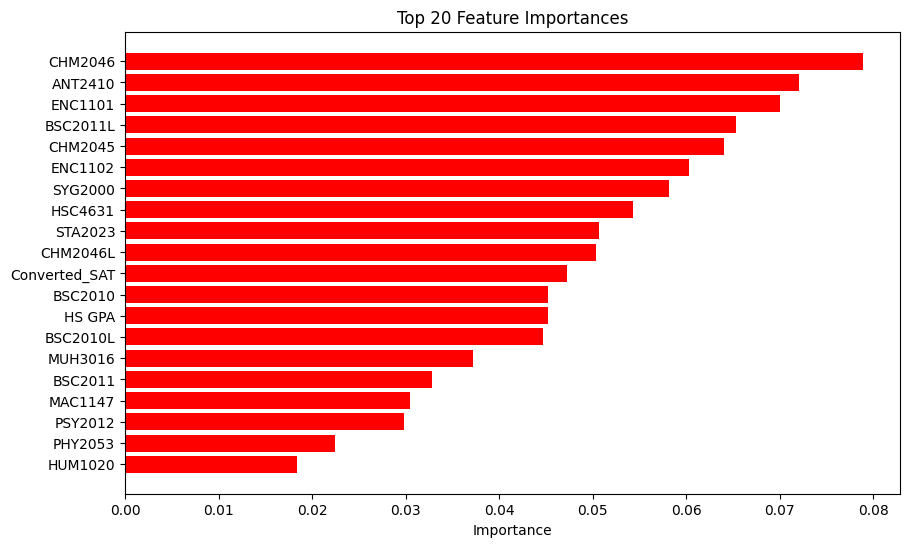

In [50]:
# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()